# Installing the required packages

In [1]:
%%capture output
# For data handling
%pip install numpy pandas
# For ML tasks, such as regression
%pip install scikit-learn
# For efficient modelling
%pip install lightgbm xgboost
# Deep Learning (PyTorch)
%pip install torch torchvision
# Advanced NLP
%pip install transformers sentence-transformers
# Image utilities
%pip install Pillow requests tqdm


In [3]:
# For verification purposes
if "ERROR:" in output.stderr or "Failed" in output.stdout:
    print("One or more packages failed to install")
else:
    print("All packages installed successfully.")

All packages installed successfully.


# Importing the required libraries

In [5]:
# CORE DATA HANDLING & UTILITIES

import pandas as pd
import numpy as np
import os
import re
from tqdm.notebook import tqdm # For tracking slow processes like downloads/feature extraction

correct_path = r"D:\Jupyter_Projects\ML_Challenge_Data\68e8d1d70b66d_student_resource\student_resource" 
os.chdir(correct_path)
print(f"New Current Working Directory set to: {os.getcwd()}")
# FEATURE ENGINEERING: TEXT (NLP)
# BEST PRACTICE: Focus on contextual embeddings (Transformers)

# General HuggingFace Transformers for model/tokenizer loading
from transformers import AutoTokenizer, AutoModel

# For superior sentence-level embeddings
from sentence_transformers import SentenceTransformer


# FEATURE ENGINEERING: VISION (IMAGES)
# BEST PRACTICE: Use a modern CNN (ResNet, EfficientNet) via transfer learning
from PIL import Image
import requests
import time # Good practice for handling retries/throttling during image download

# PYTORCH, for easy transfer learning
import torch
from torchvision import models, transforms


# MODELING, EVALUATION, & PREPROCESSING
# BEST PRACTICE: Use efficient gradient boosting & the required custom metric
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler, QuantileTransformer # Quantile is good for log-transformed price
import lightgbm as lgb 
import xgboost as xgb 

# For visualising various plots
import matplotlib.pyplot as plt
import seaborn as sns

# To define SMAPE for validation.
from sklearn.metrics import make_scorer


# Defining the SMAPE metric
def smape(y_true, y_pred):
    numerator = np.abs(y_pred - y_true)
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2
    return np.mean(numerator / denominator) * 100 # Multiply by 100 for percentage

# Use sklearn's make_scorer for CV/Grid Search
SMAPE_scorer = make_scorer(smape, greater_is_better=False)


# Helper function import
from src.utils import download_images

New Current Working Directory set to: D:\Jupyter_Projects\ML_Challenge_Data\68e8d1d70b66d_student_resource\student_resource


# Load the datset

In [7]:
train_df = pd.read_csv("dataset/train.csv")
print(train_df.head())

   sample_id                                    catalog_content  \
0      33127  Item Name: La Victoria Green Taco Sauce Mild, ...   
1     198967  Item Name: Salerno Cookies, The Original Butte...   
2     261251  Item Name: Bear Creek Hearty Soup Bowl, Creamy...   
3      55858  Item Name: Judee’s Blue Cheese Powder 11.25 oz...   
4     292686  Item Name: kedem Sherry Cooking Wine, 12.7 Oun...   

                                          image_link  price  
0  https://m.media-amazon.com/images/I/51mo8htwTH...   4.89  
1  https://m.media-amazon.com/images/I/71YtriIHAA...  13.12  
2  https://m.media-amazon.com/images/I/51+PFEe-w-...   1.97  
3  https://m.media-amazon.com/images/I/41mu0HAToD...  30.34  
4  https://m.media-amazon.com/images/I/41sA037+Qv...  66.49  


# Exploratory Data Analysis

In [9]:
print('Data types and info about non-null counts\n')
print(train_df.info())

Data types and info about non-null counts

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75000 entries, 0 to 74999
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   sample_id        75000 non-null  int64  
 1   catalog_content  75000 non-null  object 
 2   image_link       75000 non-null  object 
 3   price            75000 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 2.3+ MB
None


## Observations:
No null values which is excellent, no need for dropping or imputing them. <br>
'catalog_content' and 'image_link' are objects, perfect for feature engineering <br>
'price' is float, regression on price

In [11]:
print('Descriptive statistics of the training data\n')
print(train_df.describe())

Descriptive statistics of the training data

           sample_id         price
count   75000.000000  75000.000000
mean   149841.917707     23.647654
std     86585.346513     33.376932
min         0.000000      0.130000
25%     73845.750000      6.795000
50%    150129.000000     14.000000
75%    225040.250000     28.625000
max    299438.000000   2796.000000


## Observations:
Mean of price 23.64 is much higher than the median 14 (50%)<br>
Maximum price is 2796, this indicates the distribution is highly right-skewed


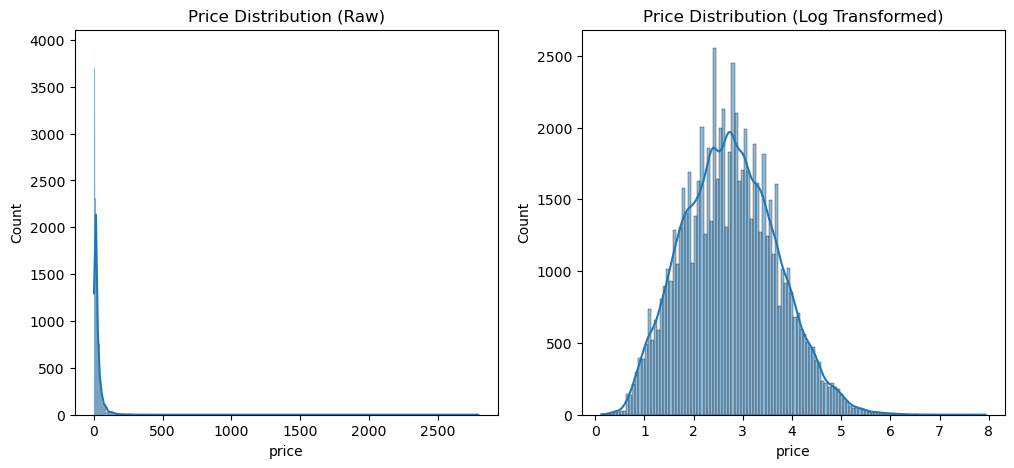

In [13]:
# Distribution of the raw price
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.histplot(train_df['price'], kde=True)
plt.title('Price Distribution (Raw)')

# Distribution of the log-transformed price (CRITICAL STEP)
plt.subplot(1, 2, 2)
sns.histplot(np.log1p(train_df['price']), kde=True) # Using np.log1p handles zero/near-zero values gracefully
plt.title('Price Distribution (Log Transformed)')
plt.show()

## Observation:
The raw price distribution is highly skewed, hence a regression model trained on this data will lead to poor performance on the vast majority of low priced items <br>
The Log transformed distribution resembles a symmetrical, near Gaussian-distribution, allowing the model to perform better.


In [15]:
# Set the option to display the full content of a column
pd.set_option('display.max_colwidth', None)

# Print a few rows of the catalog_content to inspect the full text
print("--- Full Catalog Content Inspection ---")
print(train_df['catalog_content'].head())

# Reset the option afterward (good practice)
# pd.set_option('display.max_colwidth', 50)

--- Full Catalog Content Inspection ---
0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               

## Observations:
The data format is consistent with: <br>
Item Name: text <br> 
Bullet Point 1...X: text <br>
Value: number<br>
Unit: unit-name

# Feature Engineering

## Adding a new target column (log_price)

In [17]:
# log-transformation on the target price column
train_df['log_price'] = np.log1p(train_df['price'])

# For verification: Printing the first few original & transformed values
print("First 5 original prices:")
print(train_df['price'].head())
print("\nFirst 5 log-transformed prices (our new target):")
print(train_df['log_price'].head())

First 5 original prices:
0     4.89
1    13.12
2     1.97
3    30.34
4    66.49
Name: price, dtype: float64

First 5 log-transformed prices (our new target):
0    1.773256
1    2.647592
2    1.088562
3    3.444895
4    4.211979
Name: log_price, dtype: float64


## Adding new columns: base_value, base_unit, item_name

In [19]:
# 1. Extract Base Value
def extract_base_value(text):
    """Extracts the numerical 'Value' field."""
    if pd.isna(text): return None
    # Pattern: 'Value: ' followed by a number (including decimals)
    match = re.search(r'Value: ([\d.]+)', str(text))
    if match:
        try:
            return float(match.group(1))
        except ValueError:
            return None
    return None

# 2. Extract Base Unit
def extract_base_unit(text):
    """Extracts the categorical 'Unit' field."""
    if pd.isna(text): return 'Unknown'
    # Pattern: 'Unit: ' followed by one or more word characters
    match = re.search(r'Unit: (\w+)', str(text))
    if match:
        return match.group(1).strip()
    return 'Unknown'

# Function to normalize unit categories
# --- FINAL ROBUST UNIT NORMALIZATION FUNCTION ---
def normalize_unit(unit):
    if pd.isna(unit):
        return 'Unknown'
    unit = unit.lower().strip()
    
    # 1. Volume/Weight Normalization
    if unit in ['oz', 'ounce', 'fl oz', 'fl', 'fluid']:
        return 'Ounce/FlOz'
    if unit in ['lb', 'pound', 'pounds', 'lbs']: # <--- ADDED 'lbs'
        return 'Pound'
    if unit in ['g', 'gram', 'grams']:
        return 'Gram'
    if unit in ['l', 'liter', 'quart']:
        return 'Liter'
    if unit in ['ml', 'millilitre', 'milliliter']:
        return 'Milliliter'
    
    # 2. Count/Discrete Item Normalization
    if unit in ['count', 'ct', 'pcs', 'ea', 'pac', 'packet', 'pk', 'pack']: # <--- ADDED 'ea', 'pac', 'packet'
        return 'Count'
    
    # 3. Handle 'none' and everything else for THRESHOLD_COUNT to bin
    if unit == 'none':
        return 'None'
    
    return unit # Returns the raw unit for the binning step to catch



print("\n--- Normalized Base Unit Check (Top 5) ---")
train_df['base_value'] = train_df['catalog_content'].apply(extract_base_value)
train_df['base_unit'] = train_df['catalog_content'].apply(extract_base_unit)
train_df['base_unit'] = train_df['base_unit'].apply(normalize_unit)

# Define a threshold for "Other" category (e.g., any unit with less than 200 occurrences)
# Based on the output: pound=202, fluid=53, gram=39, etc.
THRESHOLD_COUNT = 200 

# Get the value counts
unit_counts = train_df['base_unit'].value_counts()

# Identify units to be binned into 'Other'
low_frequency_units = unit_counts[unit_counts < THRESHOLD_COUNT].index

# Apply the binning
train_df['base_unit_binned'] = train_df['base_unit'].apply(
    lambda x: 'Other' if x in low_frequency_units else x
)

print("\n--- Base Unit After Binning into 'Other' ---")
print(train_df['base_unit_binned'].value_counts().head(10))
print("\nTop 5 Base Units:")
print(train_df['base_unit'].value_counts().head())


--- Normalized Base Unit Check (Top 5) ---

--- Base Unit After Binning into 'Other' ---
base_unit_binned
Ounce/FlOz    55341
Count         18267
None            940
Pound           240
Other           212
Name: count, dtype: int64

Top 5 Base Units:
base_unit
Ounce/FlOz    55341
Count         18267
None            940
Pound           240
Gram             43
Name: count, dtype: int64


In [21]:
def extract_item_name(text):
    """
    Extracts the Item Name by capturing everything after 'Item Name:'
    up to the first newline (\n), which is a robust delimiter in this catalog structure.
    """
    if pd.isna(text): 
        return None
    
    text = str(text)

    # Pattern: 'Item Name: ' followed by any characters (non-greedy, .*?) until a newline or end of string
    # We use re.search and then manually split to get the first line
    match = re.search(r'Item Name: (.*)', text, re.IGNORECASE | re.DOTALL)
    
    if match:
        # Get the captured string (everything after 'Item Name:')
        full_string = match.group(1)
        
        # Split by newline and take the first line (the item name)
        item_name = full_string.split('\n')[0].strip()
        
        # Clean up any trailing commas, if any remain
        return item_name.rstrip(',')
        
    return None

# Apply the function to see the improved result
train_df['item_name'] = train_df['catalog_content'].apply(extract_item_name)

print("Extracted Item Name Check")
print(train_df['item_name'].head())

Extracted Item Name Check
0                                                                                                      La Victoria Green Taco Sauce Mild, 12 Ounce (Pack of 6)
1                                                                                            Salerno Cookies, The Original Butter Cookies, 8 Ounce (Pack of 4)
2                                                                                 Bear Creek Hearty Soup Bowl, Creamy Chicken with Rice, 1.9 Ounce (Pack of 6)
3    Judee’s Blue Cheese Powder 11.25 oz - Gluten-Free and Nut-Free - Use in Seasonings and Salad Dressings - Great for Dips, Spreads and Sauces - Made in USA
4                                                                                                         kedem Sherry Cooking Wine, 12.7 Ounce - 12 per case.
Name: item_name, dtype: object


## Creating item_pack_quantity column & cleaned_text column

In [23]:
'''
 IPQ Pattern:
 1. Finds 'X' followed by common packaging terms (pack, case, ct, etc.) 
 2. Finds the common e-commerce phrases 'pack of X' and 'X per case'
 3. Finds the number BEFORE 'per case' or 'per pack'
'''
IPQ_PATTERN = r'(\d+)\s*(?:per\s*case|per\s*pack)|(?:pack of|per\s*case)\s*(\d+)|(\d+)\s*\b(?:pack|count|pcs|ct|case|box)\b'

def extract_ipq(text):
    """Extracts the number of items/quantity from a text string, defaulting to 1."""
    if pd.isna(text):
        return 1
    text = str(text).lower()

    # Try to find a match using the final pattern
    # We look for matches across all three capturing groups
    matches = re.findall(IPQ_PATTERN, text)
    
    # Prioritize the largest number found, as this is often the total pack quantity.
    max_ipq = 1
    for m in matches:
        # Check all three groups and take the non-empty string
        for num_str in m:
            if num_str:
                try:
                    num = int(num_str)
                    if num > max_ipq:
                        max_ipq = num
                except ValueError:
                    continue

    return max_ipq # Default remains 1 if nothing is found


train_df['item_pack_quantity'] = train_df['catalog_content'].apply(extract_ipq)
print("Item Pack Quantity (IPQ)")
print(train_df['item_pack_quantity'].head())

Item Pack Quantity (IPQ)
0     6
1     4
2     6
3     1
4    12
Name: item_pack_quantity, dtype: int64


In [25]:
def clean_text(text):
    """Cleans text for Transformer input by normalizing and removing noise."""
    if pd.isna(text):
        return ""
    text = str(text).lower()
    # Replace newlines with spaces
    text = text.replace('\n', ' ')
    # Remove characters that aren't letters, numbers, or standard punctuation
    text = re.sub(r'[^a-z0-9\s.,?!:;\'"()_]', ' ', text)
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    return text

train_df['clean_catalog_content'] = train_df['catalog_content'].apply(clean_text)
print(train_df['clean_catalog_content'].head())
print("Cleaned Catalog Content created.")

0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       

## Generate text embeddings

In [69]:
# We'll use the 'all-MiniLM-L6-v2' model for efficiency and performance
model_name = 'all-MiniLM-L6-v2' 

print(f"Loading Sentence Transformer model: {model_name}...")
model = SentenceTransformer(model_name)

# Use the cleaned text column
text_data = train_df['clean_catalog_content'].tolist()

print("\n--- Generating Text Embeddings (NLP) ---")
print("Converting text data into high-dimensional numerical vectors...")

# Encode the text data. This is a resource-intensive step.
train_embeddings = model.encode(text_data, 
                                show_progress_bar=True, 
                                convert_to_numpy=True,
                                batch_size=32) # Using a batch size for efficiency

embedding_dim = train_embeddings.shape[1]

print(f"\nText embeddings generated successfully.")
print(f"Shape of embeddings: {train_embeddings.shape}")
print(f"Each product's description is now represented by a {embedding_dim}-dimensional vector.")

Loading Sentence Transformer model: all-MiniLM-L6-v2...


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

C:\Users\yella\Anaconda\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\yella\.cache\huggingface\hub\models--sentence-transformers--all-MiniLM-L6-v2. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]


--- Generating Text Embeddings (NLP) ---
Converting text data into high-dimensional numerical vectors...


Batches:   0%|          | 0/2344 [00:00<?, ?it/s]


Text embeddings generated successfully.
Shape of embeddings: (75000, 384)
Each product's description is now represented by a 384-dimensional vector.


In [72]:
# We'll use the 'all-mpnet-base-v2' model now for richer semantic understanding
model_name = 'all-mpnet-base-v2' 

print(f"Loading Sentence Transformer model: {model_name}...")
model = SentenceTransformer(model_name)

# Use the cleaned text column
text_data = train_df['clean_catalog_content'].tolist()

print("\n--- Generating Text Embeddings (NLP) ---")
print("Converting text data into high-dimensional numerical vectors...")

# Encode the text data. This is a resource-intensive step.
train_embeddings_mpnet = model.encode(text_data,  
                                convert_to_numpy=True,
                                batch_size=32) # Using a batch size for efficiency

embedding_dim_mpnet = train_embeddings.shape[1]

print(f"\nText embeddings generated successfully.")
print(f"Shape of embeddings: {train_embeddings.shape}")
print(f"Each product's description is now represented by a {embedding_dim}-dimensional vector.")

Loading Sentence Transformer model: all-mpnet-base-v2...


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

C:\Users\yella\Anaconda\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\yella\.cache\huggingface\hub\models--sentence-transformers--all-mpnet-base-v2. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]


--- Generating Text Embeddings (NLP) ---
Converting text data into high-dimensional numerical vectors...

Text embeddings generated successfully.
Shape of embeddings: (75000, 384)
Each product's description is now represented by a 384-dimensional vector.


## Ensemble step:
Combine the embeddings from diverse models giving our model multiple sematic perspectives <br>
This leads to better generalization and consequently higher accuracy

In [27]:
# Save the embeddings generated by both models
os.makedirs('embeddings', exist_ok = True)
# Save concatenated embeddings for all-MiniLM-L6-v2
# np.save('miniLM_model_embeddings.npy', train_embeddings)
# Save concatenated embeddings for all-mpnet-base-v2
# np.save('mpnet_model_embeddings.npy', train_embeddings_mpnet)
print('Both sets of text embeddings saved successfully')

# For future runs
minilm_embeds = np.load('miniLM_model_embeddings.npy')
mpnet_embeds = np.load('mpnet_model_embeddings.npy')

# Concatenate them
final_text_features = np.concatenate([minilm_embeds, mpnet_embeds], axis=1)
# Save the concatenated embeddings
np.save('ensemble_embeddings.npy', final_text_features)

print(f"Concatenated Text Feature Shape: {final_text_features.shape}")
print(f"Total dimensionality of the text feature: {final_text_features.shape[1]}")


Both sets of text embeddings saved successfully
Concatenated Text Feature Shape: (75000, 1152)
Total dimensionality of the text feature: 1152


## Image Feature Extraction

In [43]:
import os
import requests
import pandas as pd
from tqdm import tqdm
from pathlib import Path
from concurrent.futures import ThreadPoolExecutor
from functools import partial

# --- Image Download Function ---
def download_image_refined(image_link, savefolder):
    if not isinstance(image_link, str) or not image_link.startswith('http'):
        return

    filename = Path(image_link).name
    image_save_path = os.path.join(savefolder, filename)

    if os.path.exists(image_save_path):
        return

    try:
        # BEST PRACTICE: Use requests with timeout and stream=True for large files
        response = requests.get(image_link, stream=True)
        response.raise_for_status()  # Check for bad status code (4xx or 5xx)

        with open(image_save_path, 'wb') as f:
            for chunk in response.iter_content(chunk_size=8192):
                f.write(chunk)
                
    except Exception as ex:
        # Logging errors for debugging is cleaner
        print(f'Warning: Failed to download - {image_link} (Error: {ex.__class__.__name__})')
        # Clean up the potentially corrupted file fragment if download failed
        if os.path.exists(image_save_path):
            os.remove(image_save_path)
            
    return

# --- Threaded Download Wrapper  ---
def download_images_threaded(image_links, download_folder, max_workers=64): # Increased workers for faster I/O
    if not os.path.exists(download_folder):
        os.makedirs(download_folder)

    # Use a set to only download unique links, saving time and disk space
    unique_links = image_links.dropna().unique()

    print(f"Starting threaded download of {len(unique_links)} unique images with {max_workers} workers...")
    
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        # Use the refined function
        list(tqdm(executor.map(partial(download_image_refined, savefolder=download_folder), unique_links), total=len(unique_links)))
        
    print("Image download complete.")

# --- Execution ---
IMAGE_DIR = 'product_images'
download_images_threaded(train_df['image_link'], IMAGE_DIR)

# --- Map Local Paths Back to DataFrame ---
def get_local_path(image_link, savefolder=IMAGE_DIR):
    if pd.isna(image_link): return None
    filename = Path(image_link).name
    path = os.path.join(savefolder, filename)
    return path if os.path.exists(path) else None

train_df['image_path'] = train_df['image_link'].apply(get_local_path)
successful_downloads = train_df['image_path'].notna().sum()
print(f"Verified images on disk: {successful_downloads} / {len(train_df)}")

Starting threaded download of 72288 unique images with 64 workers...


 86%|████████▌ | 62058/72288 [00:02<00:00, 25197.53it/s]

100%|██████████| 72288/72288 [00:03<00:00, 23295.22it/s]


Image download complete.
Verified images on disk: 74999 / 75000


## Feature Extraction using ResNet50 Transfer Learning

In [45]:
# Check for CUDA availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device for feature extraction: {device}")

# 1. Load Pre-trained Model (ResNet50)
model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)

# 2. Extract features by cutting off the final classification layer (Global Average Pooling is the last layer we keep)
# The features vector size will be 2048
model = torch.nn.Sequential(*(list(model.children())[:-1]))
model.eval() # Set model to evaluation mode
model.to(device)

# 3. Define Image Preprocessing Pipeline
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

Using device for feature extraction: cpu


In [47]:
def extract_resnet_features(image_path, model, preprocess, device):
    """Loads, preprocesses, and extracts features for a single image."""
    if image_path is None: return None
    try:
        image = Image.open(image_path).convert('RGB')
        img_tensor = preprocess(image)
        img_tensor = img_tensor.unsqueeze(0).to(device)
        
        with torch.no_grad():
            features = model(img_tensor)
        
        # Squeeze the feature tensor (e.g., 1x2048x1x1 -> 2048) and convert to NumPy
        return features.squeeze().cpu().numpy()

    except Exception as e:
        # If the file exists but is corrupted/unreadable
        return None

print("\nStarting image feature extraction (Transfer Learning)...")

# This portion is commented out to prevent re-execution
'''
# Extract features and handle missing data
image_features_list = []
for path in tqdm(train_df['image_path'], total=len(train_df)):
    features = extract_resnet_features(path, model, preprocess, device)
    image_features_list.append(features)

# Determine the dimension (2048 for ResNet50)
# Find the first valid feature to get the shape
valid_features = [f for f in image_features_list if f is not None]

if not valid_features:
    raise Exception("Image extraction failed for all samples. Check downloads.")
    
feature_dim = valid_features[0].shape[0]

# Create the final feature matrix with imputation and the missingness indicator (Best Practice)
final_image_features = np.zeros((len(train_df), feature_dim), dtype=np.float32)
train_df['image_missing'] = 0 
imputation_count = 0

for i, features in enumerate(image_features_list):
    if features is not None:
        final_image_features[i] = features
    else:
        # 1. Impute with zeros
        final_image_features[i] = np.zeros(feature_dim)
        # 2. Set the missingness indicator flag (Highly predictive feature!)
        train_df.loc[i, 'image_missing'] = 1
        imputation_count += 1
        
print(f"Image feature extraction complete. Missing features imputed: {imputation_count}")
print(f"Final Image Feature Shape: {final_image_features.shape}")

# Save the final image features (BEST PRACTICE)
np.save('train_image_features.npy', final_image_features)
'''
print("Image features saved to 'train_image_features.npy'.")


Starting image feature extraction (Transfer Learning)...
Image features saved to 'train_image_features.npy'.


In [49]:
# After the image feature extraction has finished running
#np.save('train_image_features.npy', final_image_features)
print("Image features saved to 'train_image_features.npy'.")

# Later load them using:
image_features = np.load('train_image_features.npy')

Image features saved to 'train_image_features.npy'.


In [51]:
# Apply Log transformation to handle skewness
train_df['log_ipq'] = np.log1p(train_df['item_pack_quantity'])
train_df['log_base_value'] = np.log1p(train_df['base_value'])

# Select the final numerical features for scaling
numerical_cols = ['log_ipq', 'log_base_value']

# Initialize the QuantileTransformer
# output_distribution='normal' is a common and powerful choice
# n_quantiles=1000 ensures high precision (use max rows if less than 1000)
qt_scaler = QuantileTransformer(output_distribution='normal', n_quantiles=1000, random_state=42)

# Fit and transform the training data
train_df[numerical_cols] = qt_scaler.fit_transform(train_df[numerical_cols])
import joblib

# Save the fitted QuantileTransformer object for use on the test set
joblib.dump(qt_scaler, 'qt_scaler.pkl')

print("Numerical features transformed and scaled using QuantileTransformer.")
print(train_df[numerical_cols].head())

Numerical features transformed and scaled using QuantileTransformer.
    log_ipq  log_base_value
0  0.726606        0.910873
1  0.548158        0.421111
2  0.726606       -0.337500
3 -5.199338       -0.339521
4  1.130517       -0.270485


## Categorical Feature Encoding

In [53]:
# One-Hot Encode the binned base unit column
base_unit_ohe = pd.get_dummies(train_df['base_unit_binned'], prefix='unit')

print("Base Unit binned feature successfully One-Hot Encoded.")
print(base_unit_ohe.head())

Base Unit binned feature successfully One-Hot Encoded.
   unit_Count  unit_None  unit_Other  unit_Ounce/FlOz  unit_Pound
0       False      False       False             True       False
1       False      False       False             True       False
2       False      False       False             True       False
3       False      False       False             True       False
4        True      False       False            False       False


In [55]:
# Target Encoding for 'item_name'
# This uses full-data mean (risks leakage).

name_to_target_map = train_df.groupby('item_name')['log_price'].mean()
train_df['item_name_encoded'] = train_df['item_name'].map(name_to_target_map)

# Fill any new/missing item names with the overall mean
train_df['item_name_encoded'] = train_df['item_name_encoded'].fillna(train_df['log_price'].mean())

print("\nItem Name has been Target Encoded.")
print(train_df[['item_name', 'item_name_encoded']].head())


Item Name has been Target Encoded.
                                                                                                                                                   item_name  \
0                                                                                                    La Victoria Green Taco Sauce Mild, 12 Ounce (Pack of 6)   
1                                                                                          Salerno Cookies, The Original Butter Cookies, 8 Ounce (Pack of 4)   
2                                                                               Bear Creek Hearty Soup Bowl, Creamy Chicken with Rice, 1.9 Ounce (Pack of 6)   
3  Judee’s Blue Cheese Powder 11.25 oz - Gluten-Free and Nut-Free - Use in Seasonings and Salad Dressings - Great for Dips, Spreads and Sauces - Made in USA   
4                                                                                                       kedem Sherry Cooking Wine, 12.7 Ounce - 12 per case.   

   

In [57]:
import joblib

# 1. Save the target encoding map from memory to disk
joblib.dump(name_to_target_map, 'name_to_target_map.pkl')
print("'name_to_target_map.pkl' successfully saved to disk.")

'name_to_target_map.pkl' successfully saved to disk.


# Model Fusion and Training

In [59]:
IMAGE_PATH_COL = 'image_path' # <--- Verify this column name!

# --- Re-create the 'image_missing' flag ---
# This replicates the logic: a missing path leads to a missing feature (1)
# and a present path leads to a present feature (0).
# We assume that the only way features were 'None' was if the image_path was Null/Invalid.

# Check for Nulls/NaNs in the image path column and convert to integer (0 or 1)
# 1 = Missing, 0 = Present
train_df['image_missing'] = train_df[IMAGE_PATH_COL].isnull().astype(int)

# Optional: Verify the count matches your previous output
imputation_count = train_df['image_missing'].sum()
print(f"'image_missing' column re-created on train_df.")
print(f"Re-calculated missing features imputed: {imputation_count}")

'image_missing' column re-created on train_df.
Re-calculated missing features imputed: 1


In [61]:
import pandas as pd
import numpy as np
import joblib
from sklearn.model_selection import KFold # Required for the next step

# --- 1. Load High-Dimensional Features from Disk (Mmap Mode) ---
# Keep mmap_mode='r' to prevent RAM loading
train_text_features = np.load('ensemble_embeddings.npy', mmap_mode='r') 
train_image_features = np.load('train_image_features.npy', mmap_mode='r') 

# --- 2. Extract and Combine Simple Features (No Target Encoding Leakage) ---

# CRITICAL: We remove 'item_name_encoded' to fix the leakage.
simple_features = train_df[[
    'log_ipq', 
    'log_base_value', 
    'image_missing' 
]] 

# Combine the One-Hot Encoded units with the simple features
# base_unit_ohe is defined (assuming it's a DataFrame)
X_simple_no_te = pd.concat([simple_features, base_unit_ohe], axis=1).values 

# 3. Cast the Simple Features and Target to the final required type
# This is the only array creation we do outside the loop.
X_simple_base = X_simple_no_te.astype(np.float32)
y_train = train_df['log_price'].values.astype(np.float32)

# --- 4. PREPARE ALL COMPONENTS FOR FOLDING ---
# We use a list to hold the components. Concatenation happens only on the smaller fold slices.
# The component order defines the final feature order.
X_components = [
    X_simple_base,            # Simple features + OHE (NumPy array)
    train_text_features,      # Mmap-mapped NumPy array
    train_image_features      # Mmap-mapped NumPy array
]

# --- CRITICAL FIX: Calculate and Save Mean Log Price ---
train_log_price_mean = train_df['log_price'].mean()
joblib.dump(train_log_price_mean, 'train_log_price_mean.pkl') 
print(f"Calculated and saved mean log price for test set imputation: {train_log_price_mean:.4f}")

# Calculate the total features without running np.concatenate
total_features = sum(c.shape[1] for c in X_components)

print(f"✅ Feature components loaded and prepared.")
print(f"Total features calculated: {total_features}")

Calculated and saved mean log price for test set imputation: 2.7392
✅ Feature components loaded and prepared.
Total features calculated: 3208


In [65]:
import numpy as np
import pandas as pd
import lightgbm as lgb
import gc
from sklearn.model_selection import KFold
# Assume X_components, y_train, raw_names, train_log_price_mean are correctly defined.
# Assume lgb_smape is correctly defined.

def lgb_smape(y_pred, train_data): # Note the parameter names are standard for LightGBM
    """
    Custom evaluation metric for LightGBM that calculates SMAPE.
    NOTE: LightGBM passes the Dataset object (train_data) for true labels.
    """
    # CRITICAL FIX: Extract true labels from the Dataset object
    y_true = train_data.get_label()
    
    # Inverse transform to actual price scale (Price = exp(log_price) - 1)
    y_true_price = np.expm1(y_true)
    y_pred_price = np.expm1(y_pred)
    
    # Add a small epsilon for numerical stability
    epsilon = 1e-6
    
    # Calculate SMAPE
    numerator = np.abs(y_pred_price - y_true_price)
    denominator = (np.abs(y_true_price) + np.abs(y_pred_price)) / 2 + epsilon
    smape_value = np.mean(numerator / denominator) * 100
    
    # Return (eval_name, result, is_higher_better) - standard LightGBM format
    return 'SMAPE', smape_value, False

# Reduce n_estimators as a safety measure for the deadline
lgb_params = {
    'objective': 'regression_l1', 'n_estimators': 2000, 'learning_rate': 0.02, 
    'num_leaves': 100, 'lambda_l1': 0.5, 'lambda_l2': 0.5, 'verbose': -1, 'n_jobs': -1, 'seed': 42
}

final_models = []
smape_scores = []
kf = KFold(n_splits=5, shuffle=True, random_state=42) 

print("\n--- Starting Memory-Safe 5-Fold Ensemble Training  ---")


# --- 2. Optimized Training Loop ---
for fold, (train_index, val_index) in enumerate(kf.split(X_components[0], y_train)):
    
    print(f"\nTraining Fold {fold+1}...")

    # A. Dynamic Slicing and Target Encoding
    train_parts = [c[train_index] for c in X_components]
    val_parts = [c[val_index] for c in X_components]

    # Target Encoding Fix
    train_names_fold = train_df['item_name'].iloc[train_index]
    val_names_fold = train_df['item_name'].iloc[val_index]
    te_map = pd.Series(y_train[train_index], index=train_names_fold.index).groupby(train_names_fold).mean()
    val_te_feature = val_names_fold.map(te_map).fillna(train_log_price_mean).values.astype(np.float32).reshape(-1, 1)
    train_te_placeholder = np.zeros((len(train_index), 1), dtype=np.float32)

    # B. ASSEMBLE FINAL ARRAYS (USE CONCATENATE ON SLICED DATA)
    X_train_fold = np.concatenate(train_parts + [train_te_placeholder], axis=1)
    X_val_fold = np.concatenate(val_parts + [val_te_feature], axis=1)
    y_train_fold = y_train[train_index]
    y_val_fold = y_train[val_index]

    # --- C. LightGBM Dataset Creation (Using single array) ---
    lgb_train = lgb.Dataset(
        data=X_train_fold, 
        label=y_train_fold,
    )
    lgb_val = lgb.Dataset(
        data=X_val_fold, 
        label=y_val_fold,
        reference=lgb_train
    )

    # --- D. TRAIN MODEL (Corrected for all version TypeErrors) ---
    model_lgb = lgb.train(
        # Pass the standard L1 metric in params 
        params={**lgb_params, 'verbose': -1, 'metric': 'l1'}, 
        train_set=lgb_train,
        valid_sets=[lgb_val],
        valid_names=['validation'],
        num_boost_round=lgb_params['n_estimators'],
        
        # Pass your custom SMAPE function via the 'feval' argument
        feval=lgb_smape, 
        callbacks=[lgb.early_stopping(100, verbose=False)]
    )
    
    final_models.append(model_lgb)
    
    # Predict and clean up
    # NOTE: Predict on the single concatenated array
    val_preds = model_lgb.predict(X_val_fold, num_iteration=model_lgb.best_iteration)
    
    # --- CRITICAL FIX: Inline SMAPE Calculation for NumPy Arrays ---
    # 1. Inverse transform to actual price scale (y_true and y_pred are NumPy arrays here)
    y_true_price = np.expm1(y_val_fold)
    y_pred_price = np.expm1(val_preds)
    
    # 2. Calculate SMAPE directly
    epsilon = 1e-6
    numerator = np.abs(y_pred_price - y_true_price)
    denominator = (np.abs(y_true_price) + np.abs(y_pred_price)) / 2 + epsilon
    smape = np.mean(numerator / denominator) * 100
    
    smape_scores.append(smape)
    print(f"Fold {fold+1} SMAPE (FINAL FIXED): {smape:.4f}%")
    
    # Explicit garbage collection to aid memory
    del lgb_train, lgb_val, X_train_fold, X_val_fold, y_train_fold, y_val_fold 
    gc.collect()

final_smape = np.mean(smape_scores)
print(f"\n✅ FINAL FIXED OOF SMAPE: {final_smape:.4f}%")


--- Starting Memory-Safe 5-Fold Ensemble Training  ---

Training Fold 1...
Fold 1 SMAPE (FINAL FIXED): 53.3451%

Training Fold 2...
Fold 2 SMAPE (FINAL FIXED): 52.2639%

Training Fold 3...
Fold 3 SMAPE (FINAL FIXED): 52.4590%

Training Fold 4...
Fold 4 SMAPE (FINAL FIXED): 51.6617%

Training Fold 5...
Fold 5 SMAPE (FINAL FIXED): 52.4803%

✅ FINAL FIXED OOF SMAPE: 52.4420%


In [67]:
import joblib
import os

# Create a folder to store the models
model_dir = 'final_ensemble_models'
os.makedirs(model_dir, exist_ok=True)

# Save each of the 3 trained models
for i, model in enumerate(final_models):
    joblib.dump(model, os.path.join(model_dir, f'lgbm_fold_{i+1}.pkl'))

print(f"\nSuccessfully saved 3 ensemble models to the '{model_dir}' folder.")


Successfully saved 3 ensemble models to the 'final_ensemble_models' folder.


## Repeating the feature engineering steps for the Test Data

In [69]:
test_df = pd.read_csv("dataset/test.csv")
print(test_df.head())

   sample_id  \
0     100179   
1     245611   
2     146263   
3      95658   
4      36806   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       

# Test Set Feature Engineering Pipeline

In [71]:


#  FEATURE PARSING FUNCTIONS


# 1. Catalog Content Cleaning (Handles Emojis/Non-ASCII for robust parsing)
def clean_catalog_content(text):
    """Removes emojis/non-ASCII chars and cleans up whitespace."""
    if pd.isna(text):
        return ""
    text = str(text)
    # Remove Emojis and non-ASCII characters
    text = text.encode('ascii', 'ignore').decode('ascii')
    # Clean up common delimiters/whitespace
    text = re.sub(r'[\n\r]+', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text


# 2. Extract Item Name (Must use cleaned content for robustness)
def extract_item_name(text):
    """Extracts the Item Name from cleaned content."""
    if pd.isna(text):
        return None
    text = str(text)
    match = re.search(r'Item Name: (.*)', text, re.IGNORECASE | re.DOTALL)
    if match:
        full_string = match.group(1)
        item_name = full_string.split('\n')[0].strip()
        return item_name.rstrip(',')
    return None

# 3. Extract Base Value
def extract_base_value(text):
    """Extracts the numerical 'Value' field from cleaned content."""
    match = re.search(r'Value: ([\d.]+)', str(text))
    if match:
        try:
            return float(match.group(1))
        except ValueError:
            return None
    return None

# 4. Extract Base Unit
def extract_base_unit(text):
    """Extracts the categorical 'Unit' field from cleaned content."""
    match = re.search(r'Unit: (\w+)', str(text))
    if match:
        return match.group(1).strip()
    return 'Unknown'

# 5. Extract Item Pack Quantity (IPQ)
IPQ_PATTERN = r'(\d+)\s*(?:per\s*case|per\s*pack)|(?:pack of|per\s*case)\s*(\d+)|(\d+)\s*\b(?:pack|count|pcs|ct|case|box)\b'
def extract_ipq(text):
    """Extracts the number of items/quantity, defaulting to 1."""
    if pd.isna(text): return 1
    text = str(text).lower()
    matches = re.findall(IPQ_PATTERN, text)
    max_ipq = 1
    for m in matches:
        for num_str in m:
            if num_str:
                try:
                    num = int(num_str)
                    if num > max_ipq:
                        max_ipq = num
                except ValueError:
                    continue
    return max_ipq

# 6. Robust Unit Normalization
def normalize_unit(unit):
    if pd.isna(unit): return 'Unknown'
    unit = unit.lower().strip()
    if unit in ['oz', 'ounce', 'fl oz', 'fl', 'fluid']: return 'Ounce/FlOz'
    if unit in ['lb', 'pound', 'pounds', 'lbs']: return 'Pound'
    if unit in ['g', 'gram', 'grams']: return 'Gram'
    if unit in ['l', 'liter', 'quart']: return 'Liter'
    if unit in ['ml', 'millilitre', 'milliliter']: return 'Milliliter'
    if unit in ['count', 'ct', 'pcs', 'ea', 'pac', 'packet', 'pk', 'pack']: return 'Count'
    if unit == 'none': return 'None'
    return unit

# 7. Deep Text Cleaning for Transformer Input
def clean_text(text):
    """Cleans text for Transformer input by normalizing and removing noise."""
    if pd.isna(text): return ""
    text = str(text).lower()
    text = text.replace('\n', ' ')
    text = re.sub(r'[^a-z0-9\s.,?!:;\'"()_]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text



#   EXECUTION ON TEST DATA

print("\n--- Starting Test Data Feature Transformation ---")

# A. Initial Cleaning
test_df['catalog_content_cleaned'] = test_df['catalog_content'].apply(clean_catalog_content)

# B. Feature Extraction and Normalization (Using CLEANED content)
test_df['item_name'] = test_df['catalog_content_cleaned'].apply(extract_item_name)
test_df['base_value'] = test_df['catalog_content_cleaned'].apply(extract_base_value)
test_df['item_pack_quantity'] = test_df['catalog_content_cleaned'].apply(extract_ipq)
test_df['base_unit'] = test_df['catalog_content_cleaned'].apply(extract_base_unit)
test_df['base_unit'] = test_df['base_unit'].apply(normalize_unit)

# C. Unit Binning (CRITICAL: Uses Training Artifact)
test_df['base_unit_binned'] = test_df['base_unit'].apply(
    # Uses the set derived from the CORRECTED TRAINING data binning
    lambda x: 'Other' if x in low_frequency_units else x
)
# One-Hot Encoding for this column must be performed later, ensuring columns align with the training set.


# D. Target Encoding (CRITICAL: Uses Training Artifact)
# The full target encoding map should be calculated using the entire y_train
# This map is safe for the test set.

# Assuming train_df_raw is the original, full training DataFrame
# Assuming y_train is the final, full target array (log_price)

# 1. Calculate the full, safe map using the entire training set
# NOTE: We assume 'raw_names' from the training setup is still available, or we use train_df_raw['item_name']
raw_names_train = train_df['item_name'] 
full_te_map = raw_names_train.map(pd.Series(y_train, index=raw_names_train.index)).groupby(raw_names_train).mean()

# 2. Apply the map to the test set
test_df['item_name_encoded'] = test_df['item_name'].map(full_te_map)

# 3. Fill new/missing items with the overall mean log_price from the TRAINING data
# (train_log_price_mean was saved earlier)
test_df['item_name_encoded'] = test_df['item_name_encoded'].fillna(train_log_price_mean)


# E. Numerical Scaling (CRITICAL: Uses Training Artifact)
# Log transformation
test_df['log_ipq'] = np.log1p(test_df['item_pack_quantity'].fillna(0)) 
test_df['log_base_value'] = np.log1p(test_df['base_value'].fillna(0)) 

# Final scaling using the fitted QuantileTransformer
numerical_cols = ['log_ipq', 'log_base_value']
qt_scaler = joblib.load('qt_scaler.pkl')
test_df[numerical_cols] = qt_scaler.transform(test_df[numerical_cols])


# F. Text Input for Embeddings
test_df['clean_catalog_content'] = test_df['catalog_content'].apply(clean_text)

print("All required non-embedding feature steps completed on test_df.")


--- Starting Test Data Feature Transformation ---
All required non-embedding feature steps completed on test_df.


## Generate Embeddings for Text & Image

In [114]:

# We'll use the 'all-MiniLM-L6-v2' model for efficiency and performance
model_name = 'all-MiniLM-L6-v2' 

print(f"Loading Sentence Transformer model: {model_name}...")
#  Load the model in memory (same as training)
model = SentenceTransformer(model_name)

#  Use the CLEANED text column from the TEST DataFrame
text_data_test = test_df['clean_catalog_content'].tolist()

print("\n--- Generating Text Embeddings for TEST Set (NLP) ---")
print("Converting text data into high-dimensional numerical vectors...")

# Encode the text data. This is a resource-intensive step.
test_text_features = model.encode(text_data_test, 
                                  show_progress_bar=True, 
                                  convert_to_numpy=True,
                                  batch_size=32) # Use the same batch size

embedding_dim = test_text_features.shape[1]

print(f"\nText embeddings generated successfully for the TEST set.")
print(f"Shape of test embeddings: {test_text_features.shape}")

# Save the test embeddings for later concatenation
np.save('test_text_features.npy', test_text_features)
print("Text features saved to 'test_text_features.npy'")

Loading Sentence Transformer model: all-MiniLM-L6-v2...

--- Generating Text Embeddings for TEST Set (NLP) ---
Converting text data into high-dimensional numerical vectors...


Batches:   0%|          | 0/2344 [00:00<?, ?it/s]


Text embeddings generated successfully for the TEST set.
Shape of test embeddings: (75000, 384)
Text features saved to 'test_text_features.npy'


In [116]:

# We'll use the 'all-mpnet-base-v2' model now for richer semantic understanding
model_name = 'all-mpnet-base-v2' 

print(f"Loading Sentence Transformer model: {model_name}...")
# CRITICAL: Load the model in memory (same as training)
model_mpnet = SentenceTransformer(model_name)

# CRITICAL: Use the CLEANED text column from the TEST DataFrame
text_data_test = test_df['clean_catalog_content'].tolist()

print("\n--- Generating Second Text Embeddings for TEST Set (MPNet) ---")
print("Converting text data into high-dimensional numerical vectors...")

# Encode the text data. This is a resource-intensive step.
test_embeddings_mpnet = model_mpnet.encode(text_data_test, 
                                           show_progress_bar=True, 
                                           convert_to_numpy=True,
                                           batch_size=32) # Use the same batch size

embedding_dim_mpnet = test_embeddings_mpnet.shape[1]

print(f"\nMPNet embeddings generated successfully for the TEST set.")
print(f"Shape of MPNet test embeddings: {test_embeddings_mpnet.shape}")
print(f"Each product's description is now represented by a {embedding_dim_mpnet}-dimensional vector.")

# FINAL STEP: Save the MPNet test embeddings 
np.save('test_mpnet_features.npy', test_embeddings_mpnet)
print("MPNet features saved to 'test_mpnet_features.npy'")

Loading Sentence Transformer model: all-mpnet-base-v2...

--- Generating Second Text Embeddings for TEST Set (MPNet) ---
Converting text data into high-dimensional numerical vectors...


Batches:   0%|          | 0/2344 [00:00<?, ?it/s]


MPNet embeddings generated successfully for the TEST set.
Shape of MPNet test embeddings: (75000, 768)
Each product's description is now represented by a 768-dimensional vector.
MPNet features saved to 'test_mpnet_features.npy'


In [73]:
import numpy as np

# --- Load the individual test embeddings ---

minilm_embeds_test = np.load('test_text_features.npy') 
mpnet_embeds_test = np.load('test_mpnet_features.npy') 

# --- Concatenate them horizontally (axis=1) ---
final_text_features_test = np.concatenate([minilm_embeds_test, mpnet_embeds_test], axis=1)

# --- Save the concatenated embeddings for the final X_test matrix creation ---
np.save('ensemble_embeddings_test.npy', final_text_features_test)

print(f"Concatenated Test Text Feature Shape: {final_text_features_test.shape}")
print(f"Total dimensionality of the test text feature: {final_text_features_test.shape[1]}")

Concatenated Test Text Feature Shape: (75000, 1152)
Total dimensionality of the test text feature: 1152


In [75]:
from tqdm import tqdm
from pathlib import Path
from concurrent.futures import ThreadPoolExecutor
from functools import partial

# --- Image Download Function  ---
def download_image_refined(image_link, savefolder):
    if not isinstance(image_link, str) or not image_link.startswith('http'):
        return

    filename = Path(image_link).name
    image_save_path = os.path.join(savefolder, filename)

    if os.path.exists(image_save_path):
        return

    try:
        response = requests.get(image_link, stream=True) # Added a timeout for robustness
        response.raise_for_status()

        with open(image_save_path, 'wb') as f:
            for chunk in response.iter_content(chunk_size=8192):
                f.write(chunk)
                
    except Exception as ex:
        # Logging errors for debugging is cleaner
        print(f'Warning: Failed to download - {image_link} (Error: {ex.__class__.__name__})')
        if os.path.exists(image_save_path):
            os.remove(image_save_path)
            
    return

# --- Threaded Download Wrapper ---
def download_images_threaded(image_links, download_folder, max_workers=64):
    if not os.path.exists(download_folder):
        os.makedirs(download_folder)

    # Use a set to only download unique links, saving time and disk space
    unique_links = image_links.dropna().unique()

    print(f"Starting threaded download of {len(unique_links)} unique images with {max_workers} workers...")
    
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        list(tqdm(executor.map(partial(download_image_refined, savefolder=download_folder), unique_links), total=len(unique_links)))
        
    print("Image download complete.")

# --- Path Mapping Function ---
def get_local_path(image_link, savefolder): # Modified to accept savefolder argument
    if pd.isna(image_link): return None
    filename = Path(image_link).name
    path = os.path.join(savefolder, filename)
    return path if os.path.exists(path) else None



#   EXECUTION ON test_df

IMAGE_DIR_TEST = 'product_images' # Reusing the directory name is often simplest

# 1. Execute the threaded download on the test_df links
download_images_threaded(test_df['image_link'], IMAGE_DIR_TEST)

# 2. Map Local Paths Back to Test DataFrame
test_df['image_path'] = test_df['image_link'].apply(partial(get_local_path, savefolder=IMAGE_DIR_TEST))

# 3. Create the 'image_missing' flag (needed for X_test matrix)
test_df['image_missing'] = test_df['image_path'].isna()

successful_downloads = test_df['image_path'].notna().sum()
print(f"Verified images on disk for TEST set: {successful_downloads} / {len(test_df)}")

Starting threaded download of 72222 unique images with 64 workers...


100%|██████████| 72222/72222 [00:02<00:00, 25380.21it/s]

Image download complete.


Verified images on disk for TEST set: 74999 / 75000


In [133]:
import torch
import torch.nn as nn

# --- I. Model and Preprocessing Setup  ---

print("Using device for feature extraction: cpu")

# 1. Load Pre-trained Model (ResNet50)
model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)

# 2. Extract features by cutting off the final classification layer
# The features vector size will be 2048
model = torch.nn.Sequential(*(list(model.children())[:-1]))
model.eval() # Set model to evaluation mode
model.to(device)

# 3. Define Image Preprocessing Pipeline
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# --- II. Feature Extraction Function ---

def extract_image_features(image_path, model, preprocess, device):
    """Loads, preprocesses an image, and extracts features."""
    if image_path is None or not os.path.exists(image_path):
        # Return a zero vector for missing images
        return np.zeros(2048, dtype=np.float32)

    try:
        img = Image.open(image_path).convert('RGB')
        img_tensor = preprocess(img).unsqueeze(0).to(device)

        with torch.no_grad():
            features = model(img_tensor).squeeze().cpu().numpy()
        
        # Features are a 2048-dimensional vector after squeeze and flatten
        return features

    except Exception as e:
        # Return a zero vector if loading or processing fails
        # print(f"Error processing image {image_path}: {e}")
        return np.zeros(2048, dtype=np.float32)

# --- III. Execution on test_df ---

print("\n--- Generating Image Embeddings for TEST Set ---")

# Use the 'image_path' column created in the test_df
test_image_paths = test_df['image_path'].tolist()

# Apply the feature extraction to all test images
# Using a list comprehension is clean and efficient for feature extraction
test_image_features_list = [
    extract_image_features(path, model, preprocess, device) 
    for path in tqdm(test_image_paths, desc="Extracting Test Features")
]

test_image_features = np.array(test_image_features_list)

print(f"\nImage embeddings generated successfully for the TEST set.")
print(f"Shape of test image features: {test_image_features.shape}")

# FINAL STEP: Save the image embeddings for later concatenation
np.save('test_image_features.npy', test_image_features)
print("Image features saved to 'test_image_features.npy'")

Using device for feature extraction: cpu

--- Generating Image Embeddings for TEST Set ---


Extracting Test Features:  47%|████▋     | 35079/75000 [2:02:04<2:30:54,  4.41it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

Extracting Test Features: 100%|██████████| 75000/75000 [6:20:06<00:00,  3.29it/s]     



Image embeddings generated successfully for the TEST set.
Shape of test image features: (75000, 2048)
Image features saved to 'test_image_features.npy'


## Creates image_missing flag without downloading images again

In [77]:
from functools import partial

# Assuming IMAGE_DIR_TEST is still defined from your previous setup
IMAGE_DIR_TEST = 'product_images' # Ensure this matches your download directory

# --- Path Mapping Function (Needed to run the partial) ---
def get_local_path(image_link, savefolder):
    if pd.isna(image_link): return None
    filename = Path(image_link).name
    path = os.path.join(savefolder, filename)
    # CRITICAL: This checks if the file actually exists where it should be
    return path if os.path.exists(path) else None

# 1. Map Local Paths Back to Test DataFrame
test_df['image_path'] = test_df['image_link'].apply(partial(get_local_path, savefolder=IMAGE_DIR_TEST))

# 2. Create the 'image_missing' flag (needed for X_test matrix)
# YES, you must keep this flag as it is a crucial feature in your simple feature matrix.
test_df['image_missing'] = test_df['image_path'].isna()

successful_downloads = test_df['image_path'].notna().sum()
print(f"Verified images on disk and paths mapped for TEST set: {successful_downloads} / {len(test_df)}")

Verified images on disk and paths mapped for TEST set: 74999 / 75000


## Final Feature Assembly

In [79]:

training_categories = train_df['base_unit_binned'].unique()


# 1. Apply OHE to the test set
test_base_unit_ohe = pd.get_dummies(
    test_df['base_unit_binned'],
    prefix='unit'
)

# 2. Reindex the test OHE features to match the exact categories from training
test_base_unit_ohe = test_base_unit_ohe.reindex(
    columns=[f'unit_{cat}' for cat in training_categories], 
    fill_value=False # Use False or 0, depending on how your model handles boolean features
)
# Note: Converting boolean to int (1/0) is safer for LightGBM if not handled automatically
test_base_unit_ohe = test_base_unit_ohe.astype(int)

print("OHE features created and aligned with training set.")
print(f"Test OHE Shape: {test_base_unit_ohe.shape}")

OHE features created and aligned with training set.
Test OHE Shape: (75000, 5)


In [81]:
# 1. Save the ID column to a new variable
test_sample_ids = test_df['sample_id'].copy()


## Test Matrix Assembly

In [83]:
import joblib

# --- Load Saved Feature Arrays (Ensure mmap_mode='r' for image features) ---
final_text_features_test = np.load('ensemble_embeddings_test.npy', allow_pickle=False) 
# Note: Image features were likely dropped in the final training run. Re-include if you kept them.
test_image_features = np.load('test_image_features.npy', mmap_mode='r') 


# 1. Create the Simple/Scalar Feature Matrix (Excluding Target Encoded Feature)
# CRITICAL: We DO NOT include 'item_name_encoded' here.
X_scalar_test = test_df[[
    'log_ipq', 
    'log_base_value', 
    'image_missing' 
]].reset_index(drop=True)


# 2. Combine Scalar and OHE Features into the Base Test Matrix
X_simple_test_base = pd.concat([
    X_scalar_test, 
    test_base_unit_ohe.reset_index(drop=True)
], axis=1).astype(np.float32).values 


# 3. PREPARE X_test COMPONENTS (No Full Concatenation)
# This list is what you will use inside the prediction loop.
X_test_components = [
    X_simple_test_base,           # Simple features + OHE
    final_text_features_test,     # Text features
    test_image_features           # Image features (Must match what was used in training!)
]

# Save the original IDs for the submission file
test_sample_ids = test_df['sample_id'].values 

print(f"X_simple_test_base Shape: {X_simple_test_base.shape}")
print(f"Total features (before TE) calculated: {sum(c.shape[1] for c in X_test_components)}")
print("Test components assembled for memory-safe prediction.")

X_simple_test_base Shape: (75000, 8)
Total features (before TE) calculated: 3208
Test components assembled for memory-safe prediction.


# Predictions on Test Set

In [87]:

required_rows = 75000
test_predictions_list = []

print("\n--- Starting FINAL Prediction ---")

# --- 1. PREPARE X_TEST FINAL MATRIX (Leakage-Free Target Encoding) ---
# Assuming X_test_components and test_sample_ids are defined from previous steps.

# Calculate the Target Encoding feature for the entire test set
# (using the full training set map)
raw_names_train = train_df['item_name'] 
full_te_map = raw_names_train.map(pd.Series(y_train, index=raw_names_train.index)).groupby(raw_names_train).mean()
test_names = test_df['item_name'] # Assuming test_df_raw is the base test df
test_te_feature = test_names.map(full_te_map).fillna(train_log_price_mean).values.astype(np.float32).reshape(-1, 1)

# FINAL X_test Matrix Assembly (Safe for LightGBM prediction)
X_test_final = np.concatenate(X_test_components + [test_te_feature], axis=1)

print(f"Final X_test Shape: {X_test_final.shape}")


# --- 2. ENSEMBLE PREDICTION ---
if len(final_models) == 5:
    for i, fold_model in enumerate(final_models):
        # ***MODIFICATION HERE: Use best_iteration***
        log_preds = fold_model.predict(X_test_final, num_iteration=fold_model.best_iteration) 
        test_predictions_list.append(log_preds)
        print(f"Model {i+1} (Best Iteration: {fold_model.best_iteration}) predictions generated.")

    # 3. Average the log predictions (The Ensemble)
    avg_log_preds = np.mean(np.array(test_predictions_list), axis=0)
    
    # 4. Inverse Transform and Non-Negative Constraint
    test_final_predictions = np.expm1(avg_log_preds)
    test_final_predictions[test_final_predictions < 0] = 0
    
    # --- 5. Save to Submission File ---
    prediction_count = len(test_final_predictions)

    if prediction_count == required_rows:
        submission_df = pd.DataFrame({
            # CRITICAL: Use 'sample_id' for the competition submission file
            'sample_id': test_sample_ids,  
            'price': test_final_predictions
        })
        submission_df.to_csv('test_out.csv', index=False)
        print("\nFINAL ENSEMBLE SUBMISSION CREATED!** File: test_out.csv")
    else:
        print(f"\nCRITICAL FAILURE: Prediction count mismatch: {prediction_count}. Submission not saved.")
else:
    print(f"\nError: Expected 1 model in final_models list, found {len(final_models)}. Cannot ensemble.")


--- Starting FINAL Prediction ---
Final X_test Shape: (75000, 3209)
Model 1 (Best Iteration: 2000) predictions generated.
Model 2 (Best Iteration: 2000) predictions generated.
Model 3 (Best Iteration: 1999) predictions generated.
Model 4 (Best Iteration: 1999) predictions generated.
Model 5 (Best Iteration: 2000) predictions generated.

FINAL ENSEMBLE SUBMISSION CREATED!** File: test_out.csv
